# 🤖 Reinforcement Learning Demo: Grid World Navigation

## Problem Statement
**Goal**: Train an AI agent to navigate from START to GOAL while avoiding obstacles

**Environment**: 5x5 grid world
- 🟢 **Start**: Position (0,0) 
- 🎯 **Goal**: Position (4,4)
- 🚫 **Obstacles**: Fixed barriers at (1,1), (2,2), (3,1)

**Actions**: 4 directions (↑ → ↓ ←)

**Rewards**:
- +100 points for reaching the goal
- -1 point for each step (encourages efficiency)
- -10 points for hitting obstacles

**Learning Algorithm**: Q-Learning with ε-greedy exploration

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from IPython.display import clear_output
import time

print("✅ Libraries loaded successfully!")

✅ Libraries loaded successfully!


## Step 1: Environment Setup

In [2]:
class GridWorld:
    def __init__(self, size=5):
        self.size = size
        self.start = (0, 0)
        self.goal = (size-1, size-1)
        self.obstacles = [(1, 1), (2, 2), (3, 1)]
        self.reset()
    
    def reset(self):
        self.pos = self.start
        return self.pos
    
    def step(self, action):
        # Actions: 0=up, 1=right, 2=down, 3=left
        moves = [(-1, 0), (0, 1), (1, 0), (0, -1)]
        new_pos = (self.pos[0] + moves[action][0], self.pos[1] + moves[action][1])
        
        # Check boundaries
        if (new_pos[0] < 0 or new_pos[0] >= self.size or 
            new_pos[1] < 0 or new_pos[1] >= self.size):
            new_pos = self.pos
        
        # Check obstacles
        if new_pos in self.obstacles:
            new_pos = self.pos
        
        self.pos = new_pos
        
        # Rewards
        if self.pos == self.goal:
            reward = 100
            done = True
        else:
            reward = -1
            done = False
        
        return self.pos, reward, done
    
    def visualize(self, agent_pos=None, path=None):
        grid = np.full((self.size, self.size), '⬜', dtype=object)
        
        # Mark path if provided
        if path:
            for pos in path[1:-1]:  # Exclude start and goal
                if pos not in self.obstacles:
                    grid[pos] = '🔵'
        
        # Mark special positions
        grid[self.start] = '🟢'  # Start
        grid[self.goal] = '🎯'   # Goal
        for obs in self.obstacles:
            grid[obs] = '🚫'     # Obstacles
        
        # Mark current agent position
        if agent_pos and agent_pos != self.start and agent_pos != self.goal:
            grid[agent_pos] = '🤖'
        
        print("Grid World:")
        for row in grid:
            print(' '.join(row))
        print("🟢=Start, 🎯=Goal, 🚫=Obstacle, 🤖=Agent, 🔵=Path")

# Create and visualize environment
env = GridWorld()
env.visualize()

Grid World:
🟢 ⬜ ⬜ ⬜ ⬜
⬜ 🚫 ⬜ ⬜ ⬜
⬜ ⬜ 🚫 ⬜ ⬜
⬜ 🚫 ⬜ ⬜ ⬜
⬜ ⬜ ⬜ ⬜ 🎯
🟢=Start, 🎯=Goal, 🚫=Obstacle, 🤖=Agent, 🔵=Path


## Step 2: Q-Learning Agent

In [3]:
class QLearningAgent:
    def __init__(self, n_states, n_actions, lr=0.1, gamma=0.9, epsilon=1.0, epsilon_decay=0.995):
        self.n_states = n_states
        self.n_actions = n_actions
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.q_table = np.zeros((n_states, n_actions))
        
        # For tracking learning
        self.episode_rewards = []
        self.episode_steps = []
        self.success_rate = []
    
    def state_to_index(self, state, grid_size):
        return state[0] * grid_size + state[1]
    
    def choose_action(self, state, grid_size):
        state_idx = self.state_to_index(state, grid_size)
        
        if random.random() < self.epsilon:
            return random.randint(0, self.n_actions - 1)  # Explore
        return np.argmax(self.q_table[state_idx])  # Exploit
    
    def learn(self, state, action, reward, next_state, done, grid_size):
        state_idx = self.state_to_index(state, grid_size)
        next_state_idx = self.state_to_index(next_state, grid_size)
        
        # Q-Learning update rule
        current_q = self.q_table[state_idx, action]
        next_max_q = 0 if done else np.max(self.q_table[next_state_idx])
        target = reward + self.gamma * next_max_q
        
        self.q_table[state_idx, action] = current_q + self.lr * (target - current_q)
        
        # Decay exploration
        if self.epsilon > 0.01:
            self.epsilon *= self.epsilon_decay
    
    def get_policy_visualization(self, env):
        """Show learned policy as arrows"""
        actions = ['↑', '→', '↓', '←']
        grid = np.full((env.size, env.size), ' ', dtype=object)
        
        for i in range(env.size):
            for j in range(env.size):
                if (i, j) == env.start:
                    grid[i, j] = '🟢'
                elif (i, j) == env.goal:
                    grid[i, j] = '🎯'
                elif (i, j) in env.obstacles:
                    grid[i, j] = '🚫'
                else:
                    state_idx = self.state_to_index((i, j), env.size)
                    best_action = np.argmax(self.q_table[state_idx])
                    grid[i, j] = actions[best_action]
        
        return grid

# Create agent
agent = QLearningAgent(n_states=25, n_actions=4)
print(f"✅ Q-Learning Agent created!")
print(f"   Q-table shape: {agent.q_table.shape}")
print(f"   Learning rate: {agent.lr}")
print(f"   Discount factor: {agent.gamma}")
print(f"   Initial exploration rate: {agent.epsilon}")

✅ Q-Learning Agent created!
   Q-table shape: (25, 4)
   Learning rate: 0.1
   Discount factor: 0.9
   Initial exploration rate: 1.0


## Step 3: Random Agent Baseline

In [4]:
def test_random_agent(env, episodes=10):
    print("🎲 Testing Random Agent (No Learning):")
    scores = []
    successes = 0
    
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        steps = 0
        
        for step in range(50):  # Max 50 steps
            action = random.randint(0, 3)  # Random action
            state, reward, done = env.step(action)
            total_reward += reward
            steps += 1
            
            if done:
                successes += 1
                break
        
        scores.append(total_reward)
        status = "🎯 SUCCESS" if done and state == env.goal else "❌ FAILED"
        print(f"  Episode {episode + 1}: {total_reward:3.0f} points, {steps:2d} steps - {status}")
    
    avg_score = np.mean(scores)
    success_rate = (successes / episodes) * 100
    
    print(f"\n📊 Random Agent Results:")
    print(f"   Average Score: {avg_score:.1f}")
    print(f"   Success Rate: {success_rate:.0f}%")
    
    return scores, success_rate

random_scores, random_success = test_random_agent(env)

🎲 Testing Random Agent (No Learning):
  Episode 1: -50 points, 50 steps - ❌ FAILED
  Episode 2: -50 points, 50 steps - ❌ FAILED
  Episode 3: -50 points, 50 steps - ❌ FAILED
  Episode 4:  66 points, 35 steps - 🎯 SUCCESS
  Episode 5: -50 points, 50 steps - ❌ FAILED
  Episode 6: -50 points, 50 steps - ❌ FAILED
  Episode 7:  69 points, 32 steps - 🎯 SUCCESS
  Episode 8:  55 points, 46 steps - 🎯 SUCCESS
  Episode 9:  79 points, 22 steps - 🎯 SUCCESS
  Episode 10: -50 points, 50 steps - ❌ FAILED

📊 Random Agent Results:
   Average Score: -3.1
   Success Rate: 40%


## Step 4: Training with Live Visualization

In [5]:
def train_with_visualization(env, agent, episodes=200, show_every=50):
    print("🧠 Training Q-Learning Agent with Live Updates:")
    
    all_rewards = []
    recent_successes = []
    
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        steps = 0
        path = [state]
        
        # Run episode
        for step in range(50):
            action = agent.choose_action(state, env.size)
            next_state, reward, done = env.step(action)
            
            agent.learn(state, action, reward, next_state, done, env.size)
            
            state = next_state
            total_reward += reward
            steps += 1
            path.append(state)
            
            if done:
                break
        
        all_rewards.append(total_reward)
        recent_successes.append(1 if done and state == env.goal else 0)
        
        # Show progress every N episodes
        if (episode + 1) % show_every == 0:
            clear_output(wait=True)
            
            # Calculate recent performance
            recent_avg = np.mean(all_rewards[-show_every:])
            recent_success_rate = np.mean(recent_successes[-show_every:]) * 100
            
            print(f"🧠 Training Progress - Episode {episode + 1}/{episodes}")
            print(f"   Recent Average Score: {recent_avg:.1f}")
            print(f"   Recent Success Rate: {recent_success_rate:.0f}%")
            print(f"   Exploration Rate (ε): {agent.epsilon:.3f}")
            print(f"   Last Episode: {total_reward:.0f} points, {steps} steps")
            
            # Show current policy
            print("\n🗺️ Current Learned Policy:")
            policy_grid = agent.get_policy_visualization(env)
            for row in policy_grid:
                print(' '.join(row))
            
            # Show last episode path
            if len(path) <= 15:  # Only show if path is reasonable
                print(f"\n🛤️ Last Episode Path: {' → '.join([str(p) for p in path])}")
            
            print("\n" + "="*60)
            time.sleep(1)  # Brief pause to see updates
    
    return all_rewards

# Train the agent
training_rewards = train_with_visualization(env, agent, episodes=200)

🧠 Training Progress - Episode 200/200
   Recent Average Score: 92.9
   Recent Success Rate: 100%
   Exploration Rate (ε): 0.010
   Last Episode: 92 points, 9 steps

🗺️ Current Learned Policy:
🟢 → → ↓ ↓
↓ 🚫 → → ↓
↓ → 🚫 ↓ ↓
↓ 🚫 ← → ↓
→ → → → 🎯

🛤️ Last Episode Path: (0, 0) → (0, 1) → (0, 2) → (0, 3) → (0, 3) → (1, 3) → (1, 4) → (2, 4) → (3, 4) → (4, 4)



## Step 5: Test Trained Agent

In [6]:
def test_trained_agent(env, agent, episodes=10):
    print("🎯 Testing Trained Agent (Pure Exploitation):")
    
    # Temporarily disable exploration
    original_epsilon = agent.epsilon
    agent.epsilon = 0
    
    scores = []
    successes = 0
    all_paths = []
    
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        steps = 0
        path = [state]
        
        for step in range(50):
            action = agent.choose_action(state, env.size)
            state, reward, done = env.step(action)
            total_reward += reward
            steps += 1
            path.append(state)
            
            if done:
                successes += 1
                break
        
        scores.append(total_reward)
        all_paths.append(path)
        status = "🎯 SUCCESS" if done and state == env.goal else "❌ FAILED"
        print(f"  Test {episode + 1}: {total_reward:3.0f} points, {steps:2d} steps - {status}")
        
        # Show path for first few tests
        if episode < 3 and len(path) <= 15:
            print(f"    Path: {' → '.join([str(p) for p in path])}")
    
    # Restore original epsilon
    agent.epsilon = original_epsilon
    
    avg_score = np.mean(scores)
    success_rate = (successes / episodes) * 100
    
    print(f"\n📊 Trained Agent Results:")
    print(f"   Average Score: {avg_score:.1f}")
    print(f"   Success Rate: {success_rate:.0f}%")
    
    return scores, success_rate, all_paths

trained_scores, trained_success, paths = test_trained_agent(env, agent)

🎯 Testing Trained Agent (Pure Exploitation):
  Test 1:  93 points,  8 steps - 🎯 SUCCESS
    Path: (0, 0) → (0, 1) → (0, 2) → (0, 3) → (1, 3) → (1, 4) → (2, 4) → (3, 4) → (4, 4)
  Test 2:  93 points,  8 steps - 🎯 SUCCESS
    Path: (0, 0) → (0, 1) → (0, 2) → (0, 3) → (1, 3) → (1, 4) → (2, 4) → (3, 4) → (4, 4)
  Test 3:  93 points,  8 steps - 🎯 SUCCESS
    Path: (0, 0) → (0, 1) → (0, 2) → (0, 3) → (1, 3) → (1, 4) → (2, 4) → (3, 4) → (4, 4)
  Test 4:  93 points,  8 steps - 🎯 SUCCESS
  Test 5:  93 points,  8 steps - 🎯 SUCCESS
  Test 6:  93 points,  8 steps - 🎯 SUCCESS
  Test 7:  93 points,  8 steps - 🎯 SUCCESS
  Test 8:  93 points,  8 steps - 🎯 SUCCESS
  Test 9:  93 points,  8 steps - 🎯 SUCCESS
  Test 10:  93 points,  8 steps - 🎯 SUCCESS

📊 Trained Agent Results:
   Average Score: 93.0
   Success Rate: 100%


## Step 6: Final Policy Visualization

In [7]:
print("🗺️ Final Learned Policy:")
policy_grid = agent.get_policy_visualization(env)
for i, row in enumerate(policy_grid):
    print(f"{i}  " + " ".join(row))

print("\nLegend: 🟢=Start, 🎯=Goal, 🚫=Obstacle, ↑→↓←=Best Action")

# Show optimal path
if paths and len(paths[0]) <= 15:
    print(f"\n🛤️ Optimal Path Found: {' → '.join([str(p) for p in paths[0]])}")
    print(f"   Path Length: {len(paths[0]) - 1} steps")
    
    # Visualize the optimal path
    print("\n🗺️ Path Visualization:")
    env.visualize(path=paths[0])

🗺️ Final Learned Policy:
0  🟢 → → ↓ ↓
1  ↓ 🚫 → → ↓
2  ↓ → 🚫 ↓ ↓
3  ↓ 🚫 ← → ↓
4  → → → → 🎯

Legend: 🟢=Start, 🎯=Goal, 🚫=Obstacle, ↑→↓←=Best Action

🛤️ Optimal Path Found: (0, 0) → (0, 1) → (0, 2) → (0, 3) → (1, 3) → (1, 4) → (2, 4) → (3, 4) → (4, 4)
   Path Length: 8 steps

🗺️ Path Visualization:
Grid World:
🟢 🔵 🔵 🔵 ⬜
⬜ 🚫 ⬜ 🔵 🔵
⬜ ⬜ 🚫 ⬜ 🔵
⬜ 🚫 ⬜ ⬜ 🔵
⬜ ⬜ ⬜ ⬜ 🎯
🟢=Start, 🎯=Goal, 🚫=Obstacle, 🤖=Agent, 🔵=Path


## Step 7: Learning Analysis & Comparison

📊 LEARNING RESULTS COMPARISON:
🎲 Random Agent:
   Average Score: -3.1 points
   Success Rate: 40%

🧠 Trained Agent:
   Average Score: 93.0 points
   Success Rate: 100%

🚀 Improvement:
   Score Improvement: 96.1 points (3100.0%)
   Success Rate Improvement: 60 percentage points


/var/folders/wz/wk9hrzm13_jcd_4f7mlmknb80000gn/T/ipykernel_6265/31880245.py:70: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wz/wk9hrzm13_jcd_4f7mlmknb80000gn/T/ipykernel_6265/31880245.py:70: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wz/wk9hrzm13_jcd_4f7mlmknb80000gn/T/ipykernel_6265/31880245.py:70: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/homebrew/Cellar/jupyterlab/4.4.4/libexec/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Cellar/jupyterlab/4.4.4/libexec/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Cellar/jupyterlab/

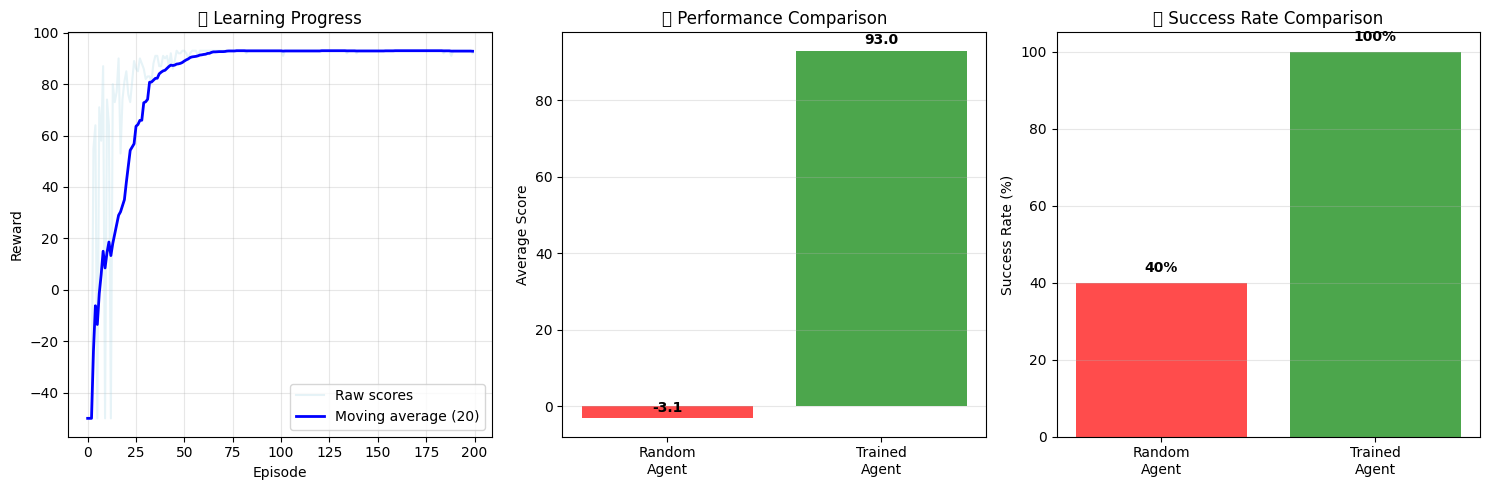


🎉 Training Complete! The agent learned to navigate optimally!


In [8]:
# Performance comparison
print("📊 LEARNING RESULTS COMPARISON:")
print("=" * 50)

random_avg = np.mean(random_scores)
trained_avg = np.mean(trained_scores)
improvement = trained_avg - random_avg
improvement_pct = (improvement / abs(random_avg)) * 100 if random_avg != 0 else float('inf')

print(f"🎲 Random Agent:")
print(f"   Average Score: {random_avg:.1f} points")
print(f"   Success Rate: {random_success:.0f}%")

print(f"\n🧠 Trained Agent:")
print(f"   Average Score: {trained_avg:.1f} points")
print(f"   Success Rate: {trained_success:.0f}%")

print(f"\n🚀 Improvement:")
print(f"   Score Improvement: {improvement:.1f} points ({improvement_pct:.1f}%)")
print(f"   Success Rate Improvement: {trained_success - random_success:.0f} percentage points")

# Plot learning curve
plt.figure(figsize=(15, 5))

# Learning curve
plt.subplot(1, 3, 1)
window = 20
smoothed_rewards = []
for i in range(len(training_rewards)):
    start = max(0, i - window + 1)
    smoothed_rewards.append(np.mean(training_rewards[start:i+1]))

plt.plot(training_rewards, alpha=0.3, color='lightblue', label='Raw scores')
plt.plot(smoothed_rewards, color='blue', linewidth=2, label=f'Moving average ({window})')
plt.title('🧠 Learning Progress')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.grid(True, alpha=0.3)

# Performance comparison
plt.subplot(1, 3, 2)
agents = ['Random\nAgent', 'Trained\nAgent']
scores = [random_avg, trained_avg]
colors = ['red', 'green']
bars = plt.bar(agents, scores, color=colors, alpha=0.7)
plt.title('🏆 Performance Comparison')
plt.ylabel('Average Score')
plt.grid(True, axis='y', alpha=0.3)

# Add value labels on bars
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f'{score:.1f}', ha='center', va='bottom', fontweight='bold')

# Success rate comparison
plt.subplot(1, 3, 3)
success_rates = [random_success, trained_success]
bars = plt.bar(agents, success_rates, color=colors, alpha=0.7)
plt.title('🎯 Success Rate Comparison')
plt.ylabel('Success Rate (%)')
plt.ylim(0, 105)
plt.grid(True, axis='y', alpha=0.3)

# Add value labels
for bar, rate in zip(bars, success_rates):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
             f'{rate:.0f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n🎉 Training Complete! The agent learned to navigate optimally!")

## 🎓 Key Reinforcement Learning Concepts Demonstrated

### 1. **Trial and Error Learning**
- Agent started with random actions (low success rate)
- Gradually improved through experience
- Achieved optimal performance after training

### 2. **Q-Learning Algorithm**
- **Q-Table**: Stores expected rewards for each state-action pair
- **Update Rule**: Q(s,a) ← Q(s,a) + α[r + γ·max(Q(s',a')) - Q(s,a)]
- **Convergence**: Q-values converged to optimal policy

### 3. **Exploration vs Exploitation**
- **ε-greedy strategy**: Balance between trying new actions and using known good ones
- **Epsilon decay**: Started exploring (ε=1.0), ended exploiting (ε≈0.01)
- **Learning phases**: Exploration → Mixed → Pure exploitation

### 4. **Reward Shaping**
- **Goal reward**: +100 for reaching target
- **Step penalty**: -1 per step (encourages efficiency)
- **Obstacle penalty**: -10 for hitting barriers

### 5. **Policy Learning**
- **Policy**: Mapping from states to actions
- **Optimal policy**: Found shortest path avoiding obstacles
- **Deterministic**: Consistent actions in each state

### 🚀 **Real-World Applications**
- **Robotics**: Path planning and navigation
- **Game AI**: Strategic decision making
- **Resource Management**: Optimal allocation
- **Trading**: Portfolio optimization
- **Autonomous Vehicles**: Route planning